My mode: VideoMode: width=640 height=480 bpp=8


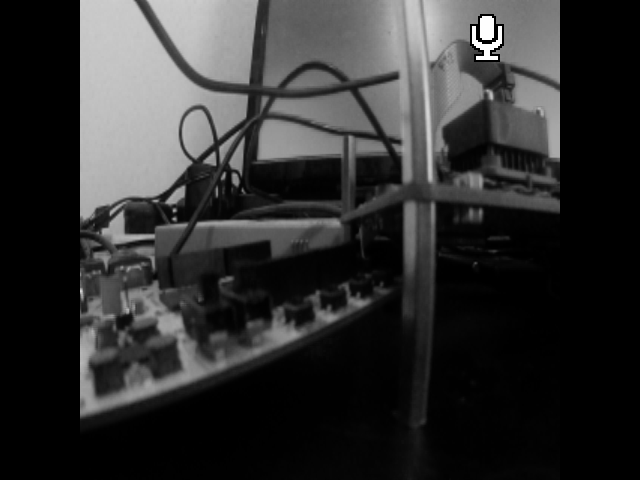

In [3]:
from pynq.lib.video import *
from pynq.overlays.bare_hdmi import BareHDMIOverlay
base = BareHDMIOverlay("/home/xilinx/pynq/overlays/computer_vision/"
                       "xv2Filter2DDilate.bit")
from pynq import Xlnk
mem_manager = Xlnk()
import pynq.overlays.computer_vision.xv2Filter2DDilate as xv2

hdmi_in = base.video.hdmi_in
hdmi_out = base.video.hdmi_out


hdmi_in.configure(PIXEL_GRAY)
hdmi_out.configure(hdmi_in.mode)

hdmi_in.start()
hdmi_out.start()

mymode = hdmi_in.mode
print("My mode: "+str(mymode))

height = hdmi_in.mode.height
width = hdmi_in.mode.width
bpp = hdmi_in.mode.bits_per_pixel

inframe = hdmi_in.readframe()
outframe = hdmi_out.newframe()
hdmi_out.writeframe(inframe)

import PIL.Image

image = PIL.Image.fromarray(inframe)
image


In [4]:
import numpy as np
import cv2

reference_blur = cv2.GaussianBlur(inframe, (5, 5), 0)
kernelVoid = np.zeros(0)
dilated = np.ndarray(shape=(hdmi_in.mode.height, hdmi_in.mode.width),dtype=np.uint8)
blur = np.ndarray(shape=(hdmi_in.mode.height, hdmi_in.mode.width),dtype=np.uint8)
numframes = 200
#outframe = hdmi_out.newframe()
kernel_g =  np.array([[0.0625,0.125,0.0625],[0.125,0.25,0.125],[0.0625,0.125,0.0625]],np.float32)

#while(True):

start = time.time()    
for _ in range(numframes):
    grey = hdmi_in.readframe()   
    xv2.filter2D(grey, -1, kernel_g, blur,(-1,-1), 0.0, borderType=cv2.BORDER_CONSTANT)
    
    difference = cv2.absdiff(reference_blur, blur)
    threshold = cv2.threshold(difference, 25, 255, cv2.THRESH_BINARY)[1]
    xv2.dilate(threshold, kernelVoid, dst=dilated, iterations=1, borderType=cv2.BORDER_CONSTANT)
    _, contours, hier = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for i in contours:
        if cv2.contourArea(i) < 2000:
            continue
        (x, y, w, h) = cv2.boundingRect(i)
        cv2.rectangle(grey, (x, y), (x + w, y + h), (0, 0, 255), 2) 
        hdmi_out.writeframe(grey)
end = time.time()
print("Frames per second:  " + str(numframes / (end - start)))

hdmi_out.close()
hdmi_in.close()

Frames per second:  29.75061900599775


In [ ]:
    #blur = cv2.GaussianBlur(grey, (5, 5), 0)   
    
    #outframe = hdmi_out.newframe()
    #outframe = grey
        
    #reference_grey = hdmi_in.readframe()
    #reference_blur = cv2.GaussianBlur(reference_grey, (5, 5), 0)
    #xv2.filter2D(reference_grey, -1, kernel_g, reference_blur,(-1,-1), 0.0, borderType=cv2.BORDER_CONSTANT)